<a href="https://colab.research.google.com/github/adeedamukhtar/Early-pneumonia-detection/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tolgadincer/labeled-chest-xray-images")

print("Path to dataset files:", path)

100%|██████████| 1.17G/1.17G [00:46<00:00, 26.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1


In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1"
print(os.listdir(dataset_path))


['chest_xray']


In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1/chest_xray"
print(os.listdir(dataset_path))


['train', 'test']


In [ ]:
import os

train_dir = "/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1/chest_xray/train"
test_dir = "/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1/chest_xray/test"

print("Train classes:", os.listdir(train_dir))
print("Test classes:", os.listdir(test_dir))


Train classes: ['PNEUMONIA', 'NORMAL']
Test classes: ['PNEUMONIA', 'NORMAL']


In [ ]:
val_dir = "/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1/chest_xray/val"

# Create new validation folders
os.makedirs(os.path.join(val_dir, "PNEUMONIA"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "NORMAL"), exist_ok=True)


In [ ]:
import shutil
import random

# Function to move files
def split_data(source, destination, split_ratio=0.2):
    files = os.listdir(source)
    num_val = int(len(files) * split_ratio)
    val_files = random.sample(files, num_val)

    for file in val_files:
        shutil.move(os.path.join(source, file), os.path.join(destination, file))

# Move images
split_data(os.path.join(train_dir, "PNEUMONIA"), os.path.join(val_dir, "PNEUMONIA"))
split_data(os.path.join(train_dir, "NORMAL"), os.path.join(val_dir, "NORMAL"))

print("Validation set created successfully!")


Validation set created successfully!


In [ ]:
import tensorflow as tf

batch_size = 32
img_size = (150, 150)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size
)

# Print class names
print("Classes:", train_ds.class_names)


Found 4187 files belonging to 2 classes.
Found 1045 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


In [ ]:
def normalize_ds(dataset):
    return dataset.map(lambda x, y: (x / 255.0, y))

train_ds = normalize_ds(train_ds)
val_ds = normalize_ds(val_ds)
test_ds = normalize_ds(test_ds)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 classes: NORMAL & PNEUMONIA
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,690 (72.61 MB)

 Trainable params: 19,034,690 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),  # Explicitly define input shape
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 classes: NORMAL & PNEUMONIA
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,690 (72.61 MB)

 Trainable params: 19,034,690 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os

# Define dataset paths
dataset_path = "/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1/chest_xray"
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")
val_dir = os.path.join(dataset_path, "val")  # If missing, we created it earlier

print("Train classes:", os.listdir(train_dir))
print("Test classes:", os.listdir(test_dir))
print("Validation classes:", os.listdir(val_dir))


Train classes: ['PNEUMONIA', 'NORMAL']
Test classes: ['PNEUMONIA', 'NORMAL']
Validation classes: ['PNEUMONIA', 'NORMAL']


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

batch_size = 32
img_size = (150, 150)

train_ds = image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size)
val_ds = image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size)
test_ds = image_dataset_from_directory(test_dir, image_size=img_size, batch_size=batch_size)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 4187 files belonging to 2 classes.
Found 1045 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


In [ ]:
from tensorflow.keras import layers

# Normalize pixel values
def normalize_ds(dataset):
    return dataset.map(lambda x, y: (x / 255.0, y))

train_ds = normalize_ds(train_ds)
val_ds = normalize_ds(val_ds)
test_ds = normalize_ds(test_ds)

# Apply data augmentation only to training data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [ ]:
from tensorflow.keras import layers, models

# Define CNN model
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')  # Output for 2 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.6919 - loss: 0.9173 - val_accuracy: 0.7435 - val_loss: 0.4794
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7431 - loss: 0.4998 - val_accuracy: 0.8431 - val_loss: 0.3923
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8267 - loss: 0.3803 - val_accuracy: 0.8708 - val_loss: 0.2956
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.8564 - loss: 0.3235 - val_accuracy: 0.9081 - val_loss: 0.2264
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.8808 - loss: 0.2894 - val_accuracy: 0.8670 - val_loss: 0.3031
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9057 - loss: 0.2450 - val_accuracy: 0.9206 - val_loss: 0.2404
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9066 - loss: 0.2329 - val_accuracy: 0.9340 - val_loss: 0.2040
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.9181 - loss: 0.2214 - val_accu

In [ ]:
test_dir = 'path/to/your/test/dataset'


In [ ]:
test_dir = r'C:\Users\username\path\to\dataset\test'


In [ ]:
import os

test_dir = 'correct/path/to/test/dataset'  # Adjust with your actual path

# Check if the directory exists
if os.path.exists(test_dir):
    print(f"The test directory exists: {test_dir}")
else:
    print(f"The test directory does not exist: {test_dir}")


The test directory does not exist: correct/path/to/test/dataset


In [ ]:
dataset_dir = '/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1'


In [ ]:
dataset_dir = '/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1'

# Example of the test directory path
test_dir = os.path.join(dataset_dir, 'test')  # Update this path based on your actual dataset location


In [ ]:
import os

# Path to the dataset
dataset_dir = '/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1'

# List the contents of the dataset directory
print("Dataset folder contents:", os.listdir(dataset_dir))


Dataset folder contents: ['chest_xray']


In [ ]:
import os

# Path to the dataset
dataset_dir = '/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1'

# List the contents of the dataset directory
print("Dataset folder contents:", os.listdir(dataset_dir))



Dataset folder contents: ['chest_xray']


In [ ]:
# Check the contents of the 'chest_xray' folder
chest_xray_dir = os.path.join(dataset_dir, 'chest_xray')
print("Chest X-ray folder contents:", os.listdir(chest_xray_dir))


Chest X-ray folder contents: ['train', 'val', 'test']


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

# Define the path to the dataset directory
dataset_dir = '/root/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1/chest_xray'

# Define subdirectories for train, validation, and test
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# Load the datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),  # Resize images to match the input size of the model
    batch_size=32,
    label_mode='int'  # Labels as integers
)

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=(150, 150),  # Resize images to match the input size of the model
    batch_size=32,
    label_mode='int'  # Labels as integers
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),  # Resize images to match the input size of the model
    batch_size=32,
    label_mode='int'  # Labels as integers
)

# Print the size of the datasets
print(f"Train dataset: {len(train_dataset)} batches")
print(f"Validation dataset: {len(val_dataset)} batches")
print(f"Test dataset: {len(test_dataset)} batches")


Found 4187 files belonging to 2 classes.
Found 1045 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Train dataset: 131 batches
Validation dataset: 33 batches
Test dataset: 20 batches


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model architecture
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),  # Rescale pixel values to [0, 1]
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 classes: Pneumonia and Normal
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # for integer labels
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7749 - loss: 0.5852 - val_accuracy: 0.9656 - val_loss: 0.1034
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9509 - loss: 0.1263 - val_accuracy: 0.9665 - val_loss: 0.0927
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9591 - loss: 0.1045 - val_accuracy: 0.9579 - val_loss: 0.1291
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9684 - loss: 0.0877 - val_accuracy: 0.9789 - val_loss: 0.0901
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9765 - loss: 0.0680 - val_accuracy: 0.9742 - val_loss: 0.0907
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9813 - loss: 0.0435 - val_accuracy: 0.9818 - val_loss: 0.0776
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9818 - loss: 0.0422 - val_accuracy: 0.9770 - val_loss: 0.0803
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9844 - loss: 0.0389 - val_accuracy: 0.978

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 344ms/step - accuracy: 0.8473 - loss: 1.3899
Test Loss: 1.3411897420883179
Test Accuracy: 0.8525640964508057


In [ ]:
# Save the trained model
model.save('pneumonia_model.h5')


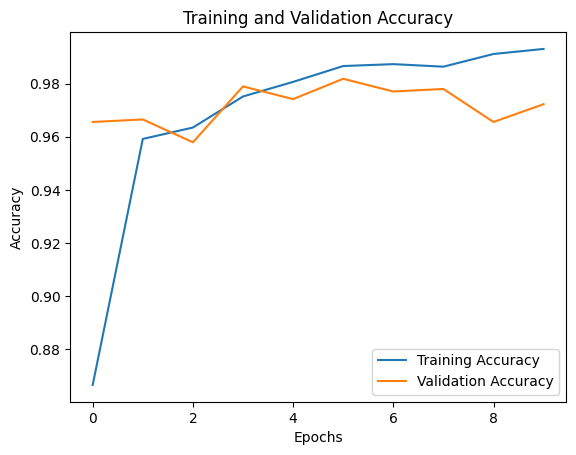

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


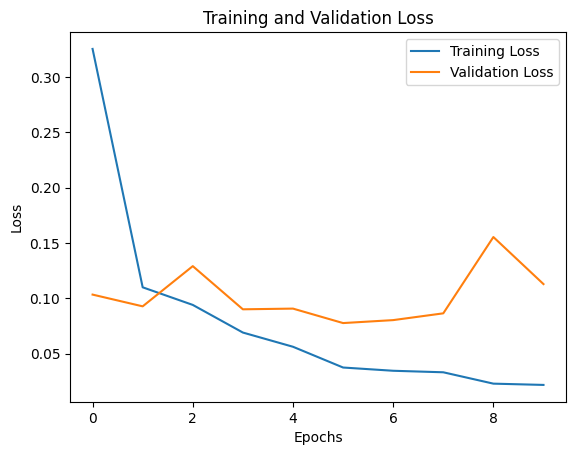

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


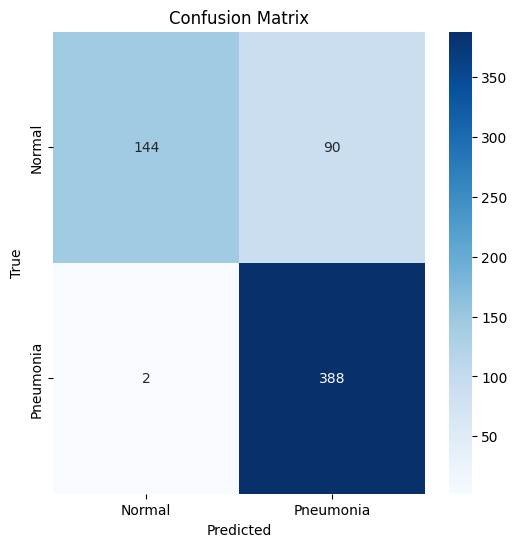

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


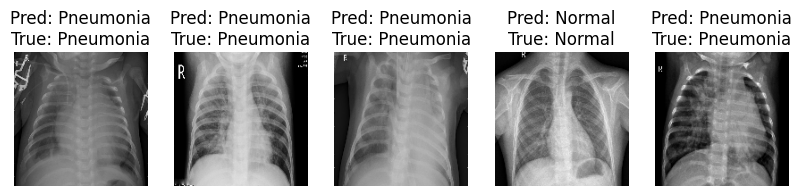

In [ ]:
import matplotlib.pyplot as plt

# Visualize a few test images and the model predictions
image_batch, label_batch = next(iter(test_dataset))

# Get predictions
predictions = model.predict(image_batch)

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    predicted_class = 'Pneumonia' if np.argmax(predictions[i]) == 1 else 'Normal'
    true_class = 'Pneumonia' if label_batch[i] == 1 else 'Normal'
    plt.title(f"Pred: {predicted_class}\nTrue: {true_class}")
    plt.axis('off')
plt.show()


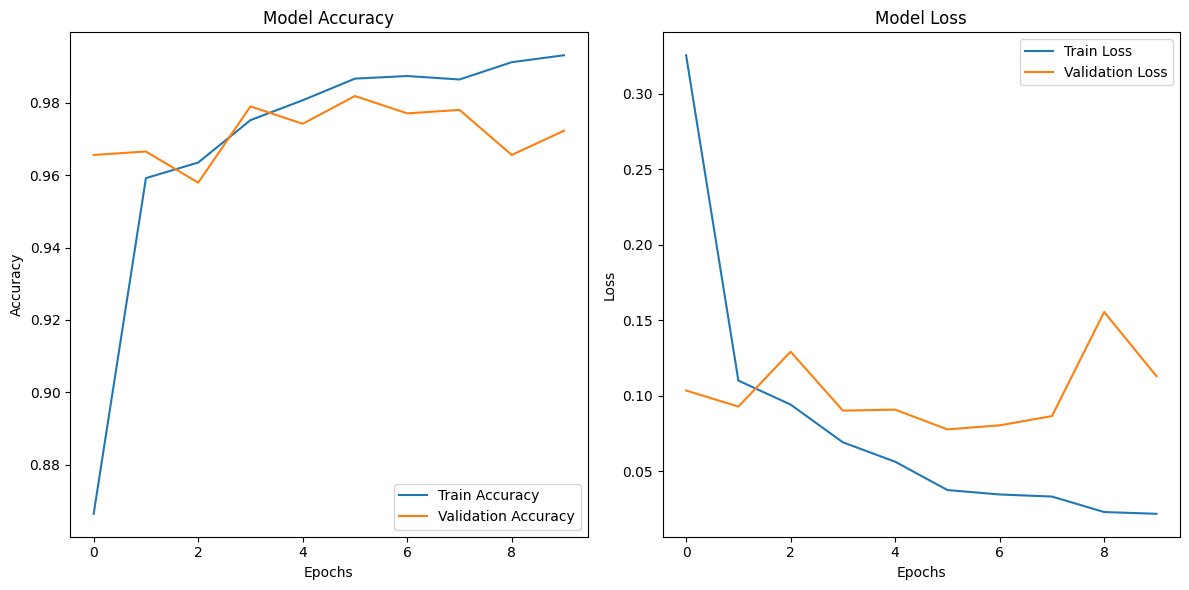

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step


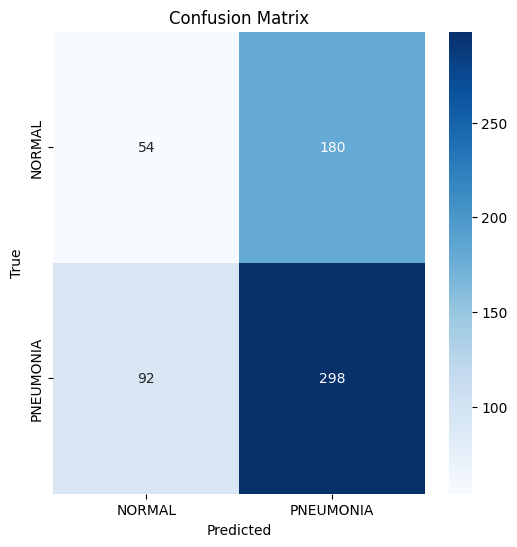

In [ ]:
import numpy as np

# Extract true labels from the test dataset
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Get labels and add them to the list

y_true = np.array(y_true)

# Get the predicted labels
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.class_names, yticklabels=test_dataset.class_names)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step


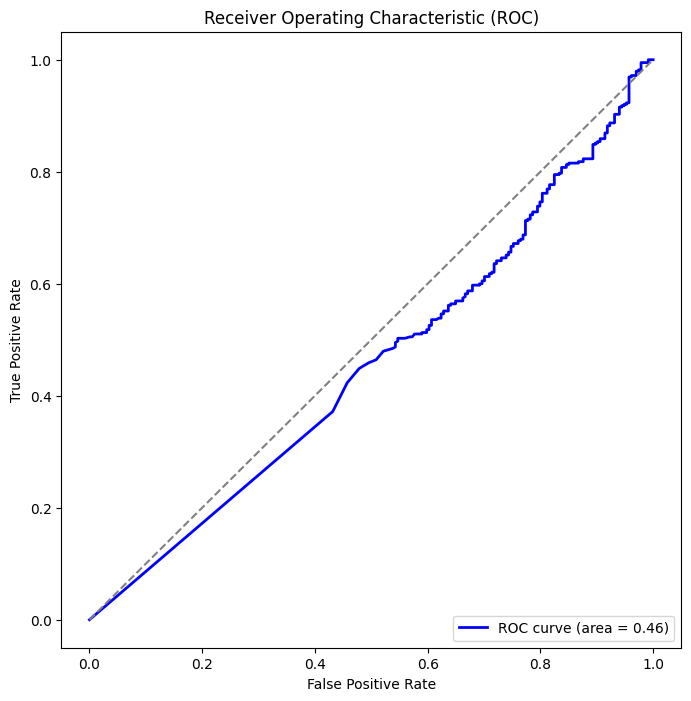

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get model predictions for ROC curve
y_pred_prob = model.predict(test_dataset)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


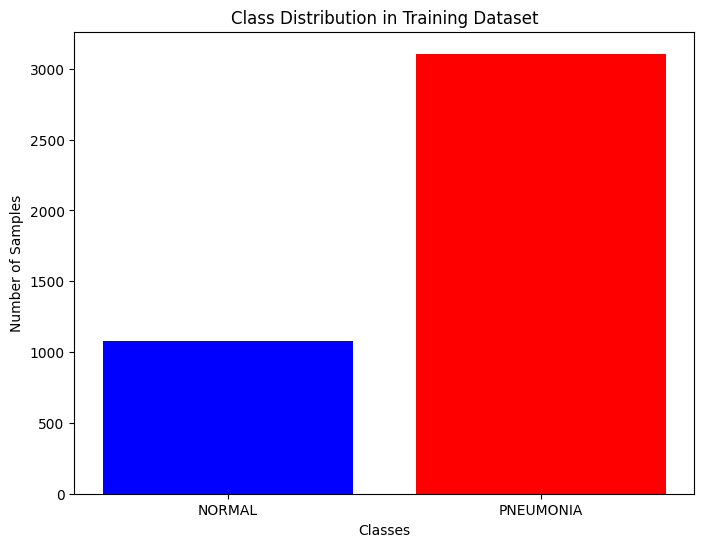

In [ ]:
# Visualizing the class distribution in the training dataset
import matplotlib.pyplot as plt

class_names = test_dataset.class_names
class_counts = [len(os.listdir(os.path.join(dataset_dir, 'train', class_name))) for class_name in class_names]

plt.figure(figsize=(8,6))
plt.bar(class_names, class_counts, color=['blue', 'red'])
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.show()


In [6]:
# prompt: save this model

# Ensure that 'model' is defined and compiled before saving
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model (or ensure previous cells with the model definition have been executed)
# prompt: save this model

# Ensure that 'model' is defined and compiled before saving
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model (or ensure previous cells with the model definition have been executed)
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu')
])

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),  # Input layer for images (150x150 pixels, 3 color channels)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    layers.MaxPooling2D((2, 2)),  # Max pooling layer to reduce spatial dimensions
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),  # Another max pooling layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling layer
    layers.Flatten(),  # Flatten the output for the dense layers
    layers.Dense(128, activation='relu'),  # Fully connected dense layer
    layers.Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Loss function for binary classification
              metrics=['accuracy'])  # Accuracy as the evaluation metric

# Save the model to a .h5 file
model.save('pneumonia_detection_model.h5')

# Print confirmation message
print("Model saved successfully.")


Model saved successfully.


In [8]:
loaded_model = tf.keras.models.load_model('pneumonia_detection_model.h5')


In [9]:
model.save('/path/to/directory/pneumonia_detection_model.h5')


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),  # Input layer for images (150x150 pixels, 3 color channels)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # Convolutional layer with ReLU activation
    layers.MaxPooling2D((2, 2)),  # Max pooling layer to reduce spatial dimensions
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),  # Another max pooling layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling layer
    layers.Flatten(),  # Flatten the output for the dense layers
    layers.Dense(128, activation='relu'),  # Fully connected dense layer
    layers.Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Loss function for binary classification
              metrics=['accuracy'])  # Accuracy as the evaluation metric

# Save the model to a .keras file (native Keras format)
model.save('pneumonia_detection_model.keras')

# Print confirmation message
print("Model saved successfully in .keras format.")


Model saved successfully in .keras format.


In [11]:
loaded_model = tf.keras.models.load_model('pneumonia_detection_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
# Save the model
model.save('pneumonia_detection_model.keras', save_format='keras')

# Load the model without the optimizer state
loaded_model = tf.keras.models.load_model('pneumonia_detection_model.keras', compile=False)

# Manually compile the model after loading
loaded_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])


In [13]:
# Save the model without specifying the save_format
model.save('pneumonia_detection_model.keras')


In [14]:
# Install Flask, TensorFlow, and other required libraries
!pip install flask tensorflow pillow


In [15]:
!pip install pyngrok


In [17]:
!ngrok config add-authtoken YOUR_AUTHTOKEN


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [19]:
!ngrok config add-authtoken 2tatu2kjw4NyOzrC1eNbRyhz5fr_7H2LhcWr39RoPZRPPUTrd


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [20]:
from pyngrok import ngrok

# Set up the ngrok tunnel to the Flask app
public_url = ngrok.connect(5000)
print(' * Flask app running at:', public_url)


 * Flask app running at: NgrokTunnel: "https://9e50-34-139-82-247.ngrok-free.app" -> "http://localhost:5000"


In [24]:
import tensorflow as tf

# Load your pre-trained model
model = tf.keras.models.load_model('pneumonia_detection_model.keras')  # Adjust the file name accordingly


In [25]:
!pip install flask-ngrok pyngrok telegram


  Preparing metadata (setup.py) ... done
  Created wheel for telegram: filename=telegram-0.0.1-py3-none-any.whl size=1293 sha256=294650948d798240b58c33445dd86ed8ec7f42beffe12d129dde3ebb070a3324
  Stored in directory: /root/.cache/pip/wheels/1e/b7/10/7a0e3b8f8c01e0d9d8a1e9913251932ca9f0a394e98ade3056
Successfully built telegram


In [28]:
import os
from flask import Flask, request, jsonify
from tensorflow.keras.preprocessing import image
import numpy as np
from flask_ngrok import run_with_ngrok
#from telegram import Bot # This line needs to be changed

# Import the correct

In [31]:
# import os
# from flask import Flask, request, jsonify
# from tensorflow.keras.preprocessing import image
# import numpy as np
# from flask_ngrok import run_with_ngrok
# #from telegram import Bot # This line needs to be changed
# from telegram import Update # remove this since Update is imported from python-telegram-bot
# from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackContext
# # Import the correct
# from telegram import Bot #

!pip install python-telegram-bot --upgrade # install the correct package

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 669.5/669.5 kB 9.2 MB/s eta 0:00:00


In [32]:
!pip install flask flask-ngrok python-telegram-bot tensorflow


In [33]:
TELEGRAM_TOKEN = '7803892322:AAFc7GrJxqxku6M5qF-MAG12Y_LY9t19X-Y'


In [36]:
import requests

# Replace with your actual Telegram token and ngrok URL
TELEGRAM_TOKEN = '7803892322:AAFc7GrJxqxku6M5qF-MAG12Y_LY9t19X-Y'
NGROK_URL = 'https://5c31-34-139-82-247.ngrok-free.app'  # Replace with your actual ngrok URL

# Set webhook URL for Telegram bot
webhook_url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/setWebhook?url={NGROK_URL}/webhook"
response = requests.get(webhook_url)

# Print the response for debugging
print(response.text)


{"ok":true,"result":true,"description":"Webhook was set"}


In [38]:
# * Flask app running at: NgrokTunnel: "https://xxxx.ngrok-free.app" -> "http://localhost:5000"
# This line is a comment and not python code, so no syntax errors to fix.
# If it were meant to be a string, it should be enclosed in quotes.
# If it were meant to be part of an f-string, it needs to be correctly formatted in a print statement or other context.
# Example:
# print(f"* Flask app running at: NgrokTunnel: \"https://xxxx.ngrok-free.app\" -> \"http://localhost:5000\"")

In [40]:
!curl -X GET "https://api.telegram.org/bot<YOUR_BOT_TOKEN>/getWebhookInfo"

{"ok":false,"error_code":404,"description":"Not Found"}

In [43]:
TOKEN = '7803892322:AAFc7GrJxqxku6M5qF-MAG12Y_LY9t19X-Y'  # Ensure the token is a string and enclosed in quotes


In [44]:
ngrok_url = "https://9e50-34-139-82-247.ngrok-free.app"  # Correct format for the URL


In [45]:
import requests

url = f"https://api.telegram.org/bot{TOKEN}/setWebhook?url={ngrok_url}/webhook"
response = requests.get(url)

print(response.json())  # Check if the response is successful


{'ok': True, 'result': True, 'description': 'Webhook was set'}


In [54]:
!pip install python-telegram-bot==20.0a3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.5/470.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 5.5.2
    Uninstalling cachetools-5.5.2:
      Successfully uninstalled cachetools-5.5.2
  Attempting uninstall: httpcore
    Found existing installation: httpcore 1.0.7
    Uninstalling httpcore-1.0.7:
      Successfully uninstalled httpcore-1.0.7
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
  Attempting uninstall: python-telegram-bot
    Found existing installation: python-telegram-bot 21.10
    Uninstalling python-telegram-bot-21.10:
      Successfully uninstalled python-telegram-bot-21.10


In [4]:
from pyngrok import ngrok

# Set up the ngrok tunnel
public_url = ngrok.connect(5000)
print('Flask app running at:', public_url)


Flask app running at: NgrokTunnel: "https://1018-34-139-82-247.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
# Get the ngrok public URL as a string
ngrok_url = public_url.public_url  # Accessing the actual URL
webhook_url = ngrok_url + "/webhook"  # The webhook route in your Flask app

# Set the webhook for the bot
set_webhook_url = f"https://api.telegram.org/bot{TOKEN}/setWebhook?url={webhook_url}"
response = requests.get(set_webhook_url)
print(response.json())  # Should print {"ok": true, "result": true, "description": "Webhook was set"}


In [6]:
# Install required libraries
!pip install flask
!pip install flask-ngrok
!pip install tensorflow
!pip install python-telegram-bot


In [7]:
import tensorflow as tf

# Load your pre-trained model (make sure it's uploaded to Colab)
model = tf.keras.models.load_model('/path/to/your/pneumonia_detection_model.h5')


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/path/to/your/pneumonia_detection_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [8]:
import tensorflow as tf

# Replace with the correct path to your saved model file
model_path = 'pneumonia_detection_model.keras'  # Assuming you saved it as 'pneumonia_detection_model.keras'

# Load the model
model = tf.keras.models.load_model(model_path)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
from flask import Flask, request, jsonify
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from flask_ngrok import run_with_ngrok

# Load the model
model = tf.keras.models.load_model('/path/to/your/pneumonia_detection_model.h5')

# Initialize Flask app
app = Flask(__name__)
run_with_ngrok(app)  # Use ngrok to expose your Flask app

@app.route('/predict', methods=['POST'])
def predict():
    # Get data from Dialogflow
    req = request.get_json(silent=True, force=True)
    img_url = req['queryResult']['parameters']['image']  # Adjust based on Dialogflow's parameter name

    # Pre-process the image (Assuming image URL is sent; if image is sent directly, adjust accordingly)
    img = image.load_img(img_url, target_size=(150, 150))  # Resize to match your model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Model prediction
    prediction = model.predict(img_array)
    result = "pneumonia" if prediction[0][0] > 0.5 else "normal"

    # Return response to Dialogflow
    return jsonify({
        'fulfillmentText': f"The detected condition is: {result}"
    })

# Run Flask app
if __name__ == '__main__':
    app.run()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/path/to/your/pneumonia_detection_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [10]:
from flask import Flask, request, jsonify
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from flask_ngrok import run_with_ngrok

# Load the model using the correct filename
model = tf.keras.models.load_model('pneumonia_detection_model.keras')

# Initialize Flask app
app = Flask(__name__)
run_with_ngrok(app)  # Use ngrok to expose your Flask app

# ... (rest of the code remains the same)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
from flask_ngrok import run_with_ngrok

# Run Flask with ngrok
ngrok_url = "2tatu2kjw4NyOzrC1eNbRyhz5fr_7H2LhcWr39RoPZRPPUTrd"  # This will be automatically created by ngrok

# This is just a placeholder. The actual URL from ngrok will be automatically available
# Use this link to set the webhook in Dialogflow
print(f"Flask app will be accessible at: {ngrok_url}")


Flask app will be accessible at: 2tatu2kjw4NyOzrC1eNbRyhz5fr_7H2LhcWr39RoPZRPPUTrd


In [ ]:
from flask_ngrok import run_with_ngrok
run_with_ngrok(app)
